### Build a simple Neural Network on SVHN dataset

#### Import the data from drive

In [204]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [205]:
import h5py
import numpy as np

# Open the file as readonly
h5f = h5py.File('/content/drive/My Drive/DLCP/Project-1/Data/SVHN_single_grey1.h5', 'r')

# Load the training, test and validation set
x_train = h5f['X_train'][:]
y_train = h5f['y_train'][:]
x_test = h5f['X_test'][:]
y_test = h5f['y_test'][:]


# Close this file
h5f.close()

x_train = x_train.reshape(x_train.shape[0], 1024)
x_test = x_test.reshape(x_test.shape[0], 1024)

# # normalize inputs from 0-255 to 0-1
x_train = x_train / 255.0
x_test = x_test / 255.0

print('Training set', x_train.shape, y_train.shape)
print('Test set', x_test.shape, y_test.shape)

Training set (42000, 1024) (42000,)
Test set (18000, 1024) (18000,)


In [206]:
print(x_train.shape)
print(y_train.shape)

(42000, 1024)
(42000,)


In [207]:
print(x_test.shape)
print(y_test.shape)


(18000, 1024)
(18000,)


### Neural network from scratch


#### Fully Connected Layer (Linear Layer)

In [0]:
import numpy as np


class Linear():
    def __init__(self, rows, cols):
        self.W = np.random.randn(rows, cols) * 0.01
        self.b = np.zeros((1, cols))
        self.params = [self.W, self.b]
        self.gradW = None
        self.gradB = None
        self.gradInput = None

    def forward(self, inputs):
        self.inputs = inputs
        self.output = np.dot(inputs, self.W) + self.b
        return self.output

    def backward(self, next_grad):
        self.gradW = np.dot(self.inputs.T, next_grad)
        self.gradB = np.sum(next_grad, axis=0)
        self.gradInput = np.dot(next_grad, self.W.T)
        return self.gradInput, [self.gradW, self.gradB]

#### Rectified Linear Activation Layer (ReLU)


In [0]:
class ReLU():
    def __init__(self):
        self.params = []
        self.gradInput = None

    def forward(self, X):
        self.output = np.maximum(X, 0)
        return self.output

    def backward(self,  next_grad):
        self.gradInput =  next_grad.copy()
        self.gradInput[self.output <=0] = 0
        return self.gradInput, []

#### Define softmax function

In [0]:
def softmax(inp):
    deno = np.sum(np.exp(inp),axis =1 , keepdims=True)
    return np.exp(inp)/ deno  

#### Define the Cross Entropy Loss

In [0]:
import numpy as np

class CrossEntropy():
    def forward(self, X, y):
        self.m = y.shape[0]
        self.p = softmax(X)
        cross_entropy = -np.log(self.p[range(self.m), y]+1e-16)
        loss = np.sum(cross_entropy) / self.m
        return loss
    
    def backward(self, X, y):
        y_idx = y.argmax()        
        grad = softmax(X)
        grad[range(self.m), y] -= 1
        grad /= self.m
        return grad
      

#### Define the container NN class that enables the forward prop and backward propagation of the entire network. Note, how this class enables us to add layers of different types and also correctly pass gradients using the chain rule.

In [0]:
class NN():
    def __init__(self):
        self.params = []
        self.layers = []
        self.grads = []
        self.loss_obj = CrossEntropy()

    def add_layer(self, layer):
        self.layers.append(layer)
        self.params.append(layer.params)

    def forward(self, inp):
        for layer in self.layers:
            inp = layer.forward(inp)
        return inp

    def backward(self, next_grad):
        self.clear_grads()
        for layer in reversed(self.layers):
            next_grad, grad = layer.backward(next_grad)
            self.grads.append(grad)
        return self.grads

    def train_step(self, x, y):
        out = self.forward(x)
        loss = self.loss_obj.forward(out, y)
        next_grad = self.loss_obj.backward(out, y)
        grads = self.backward(next_grad)
        return loss, grads

    def predict(self, x):
        x = self.forward(x)
        p = softmax(x)
        return np.argmax(p, axis=1)

    def clear_grads(self):
        self.grads = []

#### Define the update function (SGD with momentum)

In [0]:
def update_params(velocity, params, grads, learning_rate=0.01, mu=0.9):
    for v, p, g, in zip(velocity, params, reversed(grads)):
        for i in range(len(g)):
            v[i] = mu * v[i] - learning_rate * g[i]
            p[i] += v[i]

#### Define a function which gives us the minibatches (both the datapoint and the corresponding label)

In [0]:
import numpy as np
from random import shuffle

def minibatches(x_train,y_train,batchsize):
  minibatch =[]
  
  index_list = [i for i in range(x_train.shape[0])]
  shuffle(index_list)  
  
  # Shuffle the entire training data set
  x_tr = x_train[index_list, :]
  y_tr = y_train[index_list,]
  X_list = []
  Y_list = []
  i = 0
  
 # Divide the entire training set into mini batches 
  while (len(X_list) < (x_train.shape[0]/batchsize)):
    X,Y = x_tr[i:i+batchsize,], y_tr[i:i+batchsize,]
    X_list.append(X)
    Y_list.append(Y)
    i = i + batchsize
  return X_list, Y_list
        

#### The traning loop

In [0]:
def train(net, x_train, y_train, x_validation, y_validation, minibatch_size,
          nEpochs,
          learning_rate, mu=0.9):
    # Get the minibatches from the training set
    X_batchlist, Y_batchlist = minibatches(x_train, y_train, batchsize=420)

    # Training will be done 'nEpochs' times
    for n in range(nEpochs):
        loss_batch = []
        val_loss_batch = []
        velocity = []
        for param_layer in net.params:
            p = [np.zeros_like(param) for param in list(param_layer)]
            velocity.append(p)

        # Train the minibatch of training set and update the weight and bais
        # parameters as per stochastic gradient descent algorithm
        for x_batch, y_batch in zip(X_batchlist, Y_batchlist):
            loss, grads = net.train_step(x_batch, y_batch)
            loss_batch.append(loss)
            update_params(velocity, net.params, grads,
                          learning_rate=learning_rate, mu=mu)

        # Get the minibatches of Test set for validation
        x_val_list, y_val_list = minibatches(x_validation, y_validation,
                                             batchsize=420)

        # Get the average loss for validation set
        for x_val_batch, y_val_batch in zip(x_val_list, y_val_list):
            val_loss, val_grads = net.train_step(x_val_batch, y_val_batch)
            val_loss_batch.append(val_loss)

        avg_loss = sum(loss_batch) / float(len(loss_batch))
        avg_val_loss = sum(val_loss_batch) / float(len(val_loss_batch))

        # Initilaize prediction set and target set as numpy array for easier
        # data manipulation
        pred_val = np.array([], dtype='int64')
        target_val = np.array([], dtype='int64')
        accuracy_val = np.array([])
        for i in range(0, 100):
            prediction = net.predict(x_test[i])
            pred_val = np.append(pred_val, prediction)
            target_val = np.append(target_val, y_test[i])
        percent_acc = check_accuracy(target_val, pred_val)
        accuracy_val = np.append(accuracy_val, percent_acc)
        

        print("Train_Loss: {0} ; Val_loss:{1} ; percent_acc : {2} % ".format(
            avg_loss, avg_val_loss, percent_acc))
    avg_acc  = np.mean(accuracy_val)
    print("Average accuracy acheived: {} %".format(avg_acc))
    return net

#### Write a function to check the accuracy of the model 

In [0]:
def check_accuracy(target, predicted):
    mean_value = np.mean(predicted == target)
    acc_percent = mean_value * 100
    return acc_percent
    

**Invoke all that we have created until now and build a 2 linear layer Neural Network with first activation function as ReLU and second as Softmax and loss function as Cross Entropy**.

In [217]:
# Size of the input 
input_dim = x_train.shape[1]

# Hyperparameters
learning_rate = 0.03
nHiddens = 128
nLabels = 10

# Create neural network
net = NN()
net.add_layer(Linear(input_dim, nHiddens))
net.add_layer(ReLU())
net.add_layer(Linear(nHiddens, nLabels))

trained_net = train(net, x_train , y_train, x_test, y_test, minibatch_size=420, 
           nEpochs=100, learning_rate=learning_rate )

Train_Loss: 2.302248944992992 ; Val_loss:2.300728724854931 ; percent_acc : 19.0 % 
Train_Loss: 2.2950872955037154 ; Val_loss:2.2801694950162865 ; percent_acc : 26.0 % 
Train_Loss: 2.2339333230126557 ; Val_loss:2.136263942391175 ; percent_acc : 33.0 % 
Train_Loss: 1.9812683471250745 ; Val_loss:1.7759346318688176 ; percent_acc : 37.0 % 
Train_Loss: 1.6470461432173493 ; Val_loss:1.49674198993068 ; percent_acc : 56.00000000000001 % 
Train_Loss: 1.4297813497475205 ; Val_loss:1.312619158635046 ; percent_acc : 56.99999999999999 % 
Train_Loss: 1.299585022577588 ; Val_loss:1.210432716938166 ; percent_acc : 64.0 % 
Train_Loss: 1.2115645640540411 ; Val_loss:1.2050075010477577 ; percent_acc : 59.0 % 
Train_Loss: 1.1615834900101183 ; Val_loss:1.1499138500880364 ; percent_acc : 66.0 % 
Train_Loss: 1.1133757105377213 ; Val_loss:1.1141839856126639 ; percent_acc : 70.0 % 
Train_Loss: 1.070790682670418 ; Val_loss:1.0827782434273345 ; percent_acc : 70.0 % 
Train_Loss: 1.0577058454241597 ; Val_loss:1.0573

#### fprop a single image and showing its prediction

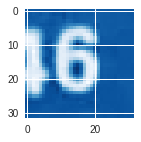

Predicted Label: [6]


In [218]:
import matplotlib.pyplot as plt

i = 130
img = x_test[i].reshape(32, 32)
figure = plt.figure(figsize=(2, 2))
plt.imshow(img, cmap="Blues_r")
plt.show()
predicted_label = trained_net.predict(x_test[i])
print("Predicted Label: {}".format(predicted_label))